In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import natsort
import re
#We gebruiken de from ... import voor commando's die we veel gebruiken om repititie te verminderen 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from keras import backend as K
from zipfile import ZipFile
import tensorflow as tf

UPLOAD EERST DE DATA ZIP in COLAB, ANDERS KAN HET VOLGENDE BLOK CODE DEZE NIET UITPAKKEN

In [2]:
standaarddirectory = os.getcwd()                  #standaarddirectory van google colab opslaan zodat we altijd terug kunnen keren naar deze
file_name = "delay_dataset.zip"                   
if not os.path.exists("stud_train"):              #Als de data nog niet uitgepakt is en deze folder dus nog niet bestaat, gaan we dit doen
  with ZipFile(file_name,'r') as zipper:
    zipper.extractall()
    print("extractie data klaar")

if not os.path.exists("stud_train_combined_ASDR"):    #Een folder waarin we de gecombineerde ASDR train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_ASDR")
if not os.path.exists("stud_train_combined_GAUSS"):   #Een folder waarin we de gecombineerde GAUSS train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_GAUSS")
if not os.path.exists("stud_train_combined_SBOX"):    #Een folder waarin we de gecombineerde SBOX train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_SBOX")

if not os.path.exists("stud_test_combined_ASDR"):    #Een folder waarin we de gecombineerde ASDR test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_ASDR")
if not os.path.exists("stud_test_combined_GAUSS"):   #Een folder waarin we de gecombineerde GAUSS test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_GAUSS")
if not os.path.exists("stud_test_combined_SBOX"):    #Een folder waarin we de gecombineerde SBOX test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_SBOX")

extractie data klaar


In [3]:
# variable declaration
train_set = 'stud_train'
test_set = 'stud_test'
delaypiekASDR = []    #array met actuele delays tussen de pieken (validatiecijfers voor training)
delaypiekGAUSS = []
delaypiekSBOX = []
delaypiekASDRtest = []    #array met actuele delays tussen de pieken (cijfers voor testing)
delaypiekGAUSStest = []
delaypiekSBOXtest = []

In [4]:
#Geeft een array met strings weer waarin de namen van de files in die map staan
def laadarraymetfilenamenuitmap(map):
    filenames = os.listdir(map)  # array met alle filenames van in folder
    filenames.sort()
    return filenames

In [5]:
#plot het signaal van een numpy array aan de hand van een megegeven signaalbestandsnaam
#Functie werd enkel gebruikt in het begin, niet meer relevant op het einde
def plotsignaal(signaal, evencheck, nummer, x = np.arange(0,512)): #signaal is naam bestand tussen aanhalingstekens
    if evencheck % 2 == 0:
        kleur = "red"         #paar van signalen respectievelijk rood en blauw weergeven zodat het verschil duidelijk is
    else:
        kleur = "blue"
    plot = plt.figure(nummer)
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.plot(x,np.load(signaal), color=kleur)

In [6]:
#Geeft de waarde van de positie van die piek terug aan de hand van de bestandsnaam
def geefpositiepiek(signaal):
  truncatedsignaal = (signaal.split("P_",1)[1]) #alles voor de xxx wegdoen dus BV ASDR_P_ wegdoen
  piek = ''.join(x for x in truncatedsignaal[0:3] if x.isdigit()) 
  return piek

In [7]:
#voegt de array van twee signalen samen om 1 vector van 1024 samples te bekomen
def voegsamen(signaal1, signaal2):
  return np.concatenate([np.load(signaal1), np.load(signaal2)])

In [8]:
#wordt gebruikt om de lijst met de files te sorten op numerische orde ipv alfabetische orde om sortering van 0 1 10 11 ... 19 2 20 21 ... 29 3 30 31 etc te voorkomen maar 0 1 2 3 4 ... 99
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [9]:
def combinedata(folder, dir, delayarray, typesignaal = "", testoftrain = "", aantalgrafiekenplotten = 0):
  i = 0
  nummer = 1
  evencheck = 0
  x = np.arange(0, 1024)
  k = 0
  for data in folder:
    evencheck += 1
    if k != 0 and evencheck % 2 == 0:
      os.chdir(f"stud_{testoftrain}")
      masterfile = voegsamen(previous, data)
      os.chdir(standaarddirectory)

      os.chdir(dir)
      savename = f"{nummer}{typesignaal}.npy"
      np.save(savename,masterfile)
      os.chdir(standaarddirectory)
      nummer += 1
      delayarray.append(512-int(geefpositiepiek(previous))+int(geefpositiepiek(data)))

      #plotten voor eerste paar grafieken, mooie visualisatie als controle
      if evencheck < ((aantalgrafiekenplotten*2)+1):  #evencheck > aantal grafieken*2, max 41 vanwege memory limiet -> 20 grafieken, zet op 1 indien je geen grafieken wil zien
        plot= plt.figure(nummer)
        plt.plot(x,masterfile, color="red")

    k += 1
    previous = data

END OF FUNCTIONS

In [10]:
#main
#filenames inlezen
filenames = laadarraymetfilenamenuitmap(train_set)
filenamesASDR = filenames[0:200]
filenamesGAUSS = filenames[200:400]
filenamesSBOX = filenames[400:600]

filenamestest = laadarraymetfilenamenuitmap(test_set)
filenamesASDRtest = filenamestest[0:200]
filenamesGAUSStest = filenamestest[200:400]
filenamesSBOXtest = filenamestest[400:600]

#sorteren
filenamesASDR.sort(key=natural_keys)
filenamesGAUSS.sort(key=natural_keys)
filenamesSBOX.sort(key=natural_keys)
filenamesASDRtest.sort(key=natural_keys)
filenamesGAUSStest.sort(key=natural_keys)
filenamesSBOXtest.sort(key=natural_keys)

In [11]:
os.chdir(standaarddirectory)
combinedata(filenamesASDR, "stud_train_combined_ASDR", delaypiekASDR, "ASDR", "train")
combinedata(filenamesGAUSS, "stud_train_combined_GAUSS", delaypiekGAUSS, "GAUSS", "train")
combinedata(filenamesSBOX, "stud_train_combined_SBOX", delaypiekSBOX, "SBOX", "train")

combinedata(filenamesASDRtest, "stud_test_combined_ASDR", delaypiekASDRtest, "ASDR", "test")
combinedata(filenamesGAUSStest, "stud_test_combined_GAUSS", delaypiekGAUSStest, "GAUSS", "test")
combinedata(filenamesSBOXtest, "stud_test_combined_SBOX", delaypiekSBOXtest, "SBOX", "test")

MODEL ASDR

In [12]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_ASDR")

samplesASDR = [np.load(f"{x}ASDR.npy") for x in range(1, 101)]
samplesASDR = tf.convert_to_tensor(samplesASDR)

os.chdir(standaarddirectory)

In [13]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_ASDR")

samplesASDRtest = [np.load(f"{x}ASDR.npy") for x in range(1, 101)]
samplesASDRtest = tf.convert_to_tensor(samplesASDRtest)

os.chdir(standaarddirectory)

In [14]:
#TENSOR object maken voor y waarden NN training
delayASDR = pd.DataFrame(data = delaypiekASDR)
delayASDR = tf.convert_to_tensor(delayASDR)

In [142]:
#Model aanmaken
modelASDR = tf.keras.Sequential()
modelASDR.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelASDR.add(layers.Dense(256, activation='relu'))
modelASDR.add(layers.Dense(128, activation='relu'))
modelASDR.add(layers.Dense(64, activation='relu'))
modelASDR.add(layers.Dense(32, activation='relu'))
modelASDR.add(layers.Dense(16, activation='relu'))
modelASDR.add(layers.Dense(8, activation='relu'))
modelASDR.add(layers.Dense(4, activation='relu'))
modelASDR.add(layers.Dense(2, activation='relu'))
modelASDR.add(layers.Dense(1))

In [143]:
modelASDR.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_107 (Dense)           (None, 512)               524800    
                                                                 
 dense_108 (Dense)           (None, 256)               131328    
                                                                 
 dense_109 (Dense)           (None, 128)               32896     
                                                                 
 dense_110 (Dense)           (None, 64)                8256      
                                                                 
 dense_111 (Dense)           (None, 32)                2080      
                                                                 
 dense_112 (Dense)           (None, 16)                528       
                                                                 
 dense_113 (Dense)           (None, 8)               

In [144]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelASDR.compile(optimizer='Adam', loss='mae', metrics=['mae'])
K.set_value(modelASDR.optimizer.learning_rate, 0.002)

Optimizer algoritmes: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers 

In [145]:
#Model Trainen
history1 = modelASDR.fit(samplesASDR,
                        delayASDR,
                        epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 13ms/step - loss: 567.2111 - mae: 567.2111
Epoch 2/20
4/4 [==============================] - 0s 19ms/step - loss: 353.2617 - mae: 353.2617
Epoch 3/20
4/4 [==============================] - 0s 20ms/step - loss: 224.5114 - mae: 224.5114
Epoch 4/20
4/4 [==============================] - 0s 15ms/step - loss: 192.4515 - mae: 192.4515
Epoch 5/20
4/4 [==============================] - 0s 13ms/step - loss: 89.5617 - mae: 89.5617
Epoch 6/20
4/4 [==============================] - 0s 21ms/step - loss: 76.1970 - mae: 76.1970
Epoch 7/20
4/4 [==============================] - 0s 13ms/step - loss: 95.1212 - mae: 95.1212
Epoch 8/20
4/4 [==============================] - 0s 11ms/step - loss: 74.6308 - mae: 74.6308
Epoch 9/20
4/4 [==============================] - 0s 11ms/step - loss: 62.8494 - mae: 62.8494
Epoch 10/20
4/4 [==============================] - 0s 12ms/step - loss: 76.6544 - mae: 76.6544
Epoch 11/20
4/4 [==============================] - 

In [146]:
predictionsASDR = modelASDR.predict(samplesASDRtest)

4/4 [==============================] - 0s 4ms/step


[99, 46, 90, 13, 48, 90, 154, 75, 22, 114, 100, 121, 1, 121, 35, 223, 124, 54, 21, 56, 24, 209, 77, 97, 9, 41, 47, 195, 165, 64, 1, 39, 93, 72, 44, 24, 18, 120, 29, 122, 33, 8, 8, 7, 58, 1, 18, 36, 5, 41, 93, 66, 167, 42, 128, 9, 40, 36, 73, 12, 0, 128, 103, 33, 2, 116, 45, 129, 47, 52, 118, 91, 45, 187, 100, 96, 123, 47, 78, 20, 160, 134, 39, 23, 32, 30, 147, 64, 87, 39, 14, 43, 84, 127, 117, 174, 15, 209, 145, 47]
[497.9231262207031, 651.6939697265625, 461.5903015136719, 611.549560546875, 607.0182495117188, 469.50653076171875, 717.3812866210938, 618.2510375976562, 581.676025390625, 428.0546875, 510.94891357421875, 688.7246704101562, 570.1364135742188, 452.94512939453125, 592.005126953125, 764.7855224609375, 483.3681945800781, 493.49517822265625, 565.8547973632812, 631.9396362304688, 565.2042846679688, 389.8118591308594, 684.82275390625, 501.10430908203125, 557.0731201171875, 506.3260803222656, 565.4789428710938, 760.3685913085938, 714.1625366210938, 612.6187744140625, 544.69793701171

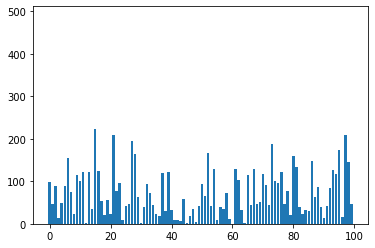

In [147]:
predictionslistASDR = predictionsASDR.tolist()
predictionslistASDRflat = [item for sublist in predictionslistASDR for item in sublist]

error_list_ASDR = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslistASDRflat, delaypiekASDRtest):
  error_list_ASDR.append(round(abs(error1 - error2)))

print(error_list_ASDR)
print(predictionslistASDRflat)
print(delaypiekASDRtest)
#visualiseren error
bar = plt.figure(1)
plt.bar(np.arange(0, 100), error_list_ASDR)
plt.ylim(0, 512)
plt.show()


GAUSS MODEL

In [21]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_GAUSS")

samplesGAUSS = [np.load(f"{x}GAUSS.npy") for x in range(1, 101)]
samplesGAUSS = tf.convert_to_tensor(samplesGAUSS)

os.chdir(standaarddirectory)

In [22]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_GAUSS")

samplesGAUSStest = [np.load(f"{x}GAUSS.npy") for x in range(1, 101)]
samplesGAUSStest = tf.convert_to_tensor(samplesGAUSStest)

os.chdir(standaarddirectory)

In [23]:
#TENSOR object maken voor y waarden NN training
delayGAUSS = pd.DataFrame(data = delaypiekGAUSS)
delayGAUSS = tf.convert_to_tensor(delayGAUSS)

In [148]:
#Model aanmaken
modelGAUSS = tf.keras.Sequential()
modelGAUSS.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelGAUSS.add(layers.Dense(256, activation='relu'))
modelGAUSS.add(layers.Dense(64, activation='relu'))
modelGAUSS.add(layers.Dense(32, activation='relu'))
modelGAUSS.add(layers.Dense(8, activation='relu'))
modelGAUSS.add(layers.Dense(1))

In [149]:
modelGAUSS.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 512)               524800    
                                                                 
 dense_118 (Dense)           (None, 256)               131328    
                                                                 
 dense_119 (Dense)           (None, 64)                16448     
                                                                 
 dense_120 (Dense)           (None, 32)                2080      
                                                                 
 dense_121 (Dense)           (None, 8)                 264       
                                                                 
 dense_122 (Dense)           (None, 1)                 9         
                                                                 
Total params: 674,929
Trainable params: 674,929
Non-t

In [150]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelGAUSS.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [151]:
#Model Trainen
history2 = modelGAUSS.fit(samplesGAUSS,
                        delayGAUSS,
                        epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 9ms/step - loss: 574.0173 - mae: 574.0173
Epoch 2/20
4/4 [==============================] - 0s 9ms/step - loss: 536.2893 - mae: 536.2893
Epoch 3/20
4/4 [==============================] - 0s 10ms/step - loss: 430.4259 - mae: 430.4259
Epoch 4/20
4/4 [==============================] - 0s 9ms/step - loss: 190.2178 - mae: 190.2178
Epoch 5/20
4/4 [==============================] - 0s 11ms/step - loss: 121.7800 - mae: 121.7800
Epoch 6/20
4/4 [==============================] - 0s 9ms/step - loss: 40.7390 - mae: 40.7390
Epoch 7/20
4/4 [==============================] - 0s 9ms/step - loss: 57.4371 - mae: 57.4371
Epoch 8/20
4/4 [==============================] - 0s 9ms/step - loss: 55.9936 - mae: 55.9936
Epoch 9/20
4/4 [==============================] - 0s 9ms/step - loss: 27.8578 - mae: 27.8578
Epoch 10/20
4/4 [==============================] - 0s 11ms/step - loss: 27.8315 - mae: 27.8315
Epoch 11/20
4/4 [==============================] - 0s 8m

In [152]:
predictionsGAUSS = modelGAUSS.predict(samplesGAUSStest)

4/4 [==============================] - 0s 5ms/step


[41, 2, 4, 11, 25, 11, 5, 12, 33, 15, 5, 8, 12, 1, 16, 1, 6, 2, 4, 7, 2, 4, 2, 36, 3, 14, 9, 27, 4, 1, 3, 34, 1, 36, 4, 4, 2, 20, 2, 27, 0, 18, 7, 12, 2, 13, 2, 89, 569, 14, 3, 29, 7, 31, 128, 4, 2, 3, 10, 4, 3, 27, 18, 34, 0, 2, 26, 9, 4, 13, 2, 11, 11, 27, 34, 5, 17, 0, 14, 11, 4, 14, 44, 6, 4, 28, 4, 27, 31, 31, 3, 37, 10, 19, 9, 2, 5, 19, 3, 19]
[592.85400390625, 590.6166381835938, 549.1429443359375, 593.02490234375, 528.7376098632812, 566.6724243164062, 592.2919921875, 566.0829467773438, 578.2357788085938, 600.685302734375, 583.6779174804688, 567.4595336914062, 600.5030517578125, 604.1951293945312, 589.3495483398438, 589.4522094726562, 580.9907836914062, 546.3546142578125, 559.2014770507812, 602.3428955078125, 602.064208984375, 601.3801879882812, 565.34228515625, 595.25439453125, 561.3540649414062, 560.5036010742188, 591.7307739257812, 633.4827880859375, 602.7745361328125, 556.2977294921875, 542.3049926757812, 600.0852661132812, 602.9868774414062, 595.4631958007812, 586.7756958007

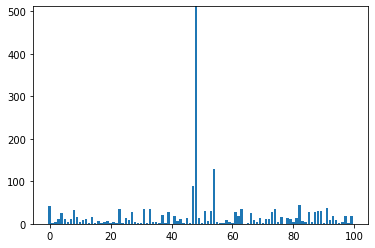

In [153]:
predictionslistGAUSS = predictionsGAUSS.tolist()
predictionslistGAUSSflat = [item for sublist in predictionslistGAUSS for item in sublist]

error_list_GAUSS = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslistGAUSSflat, delaypiekGAUSStest):
  error_list_GAUSS.append(round(abs(error1 - error2)))

print(error_list_GAUSS)
print(predictionslistGAUSSflat)
print(delaypiekGAUSStest)
#visualiseren error
bar = plt.figure(2)
plt.bar(np.arange(0, 100), error_list_GAUSS)
plt.ylim(0, 512)
plt.show()


SBOX MODEL

In [30]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_SBOX")

samplesSBOX = [np.load(f"{x}SBOX.npy") for x in range(1, 101)]
samplesSBOX = tf.convert_to_tensor(samplesSBOX)

os.chdir(standaarddirectory)

In [31]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_SBOX")

samplesSBOXtest = [np.load(f"{x}SBOX.npy") for x in range(1, 101)]
samplesSBOXtest = tf.convert_to_tensor(samplesSBOXtest)

os.chdir(standaarddirectory)

In [32]:
#TENSOR object maken voor y waarden NN training
delaySBOX = pd.DataFrame(data = delaypiekSBOX)
delaySBOX = tf.convert_to_tensor(delaySBOX)

In [33]:
#Model aanmaken
modelSBOX = tf.keras.Sequential()
modelSBOX.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelSBOX.add(layers.Dense(256, activation='relu'))
modelSBOX.add(layers.Dense(64, activation='relu'))
modelSBOX.add(layers.Dense(8, activation='relu'))
modelSBOX.add(layers.Dense(1))

In [34]:
modelSBOX.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 dense_13 (Dense)            (None, 8)                 520       
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [35]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelSBOX.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [36]:
#Model Trainen
history3 = modelSBOX.fit(samplesSBOX,
                        delaySBOX,
                        epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 12ms/step - loss: 580.8467 - mae: 580.8467
Epoch 2/20
4/4 [==============================] - 0s 9ms/step - loss: 576.2118 - mae: 576.2118
Epoch 3/20
4/4 [==============================] - 0s 9ms/step - loss: 564.5517 - mae: 564.5517
Epoch 4/20
4/4 [==============================] - 0s 9ms/step - loss: 539.2593 - mae: 539.2593
Epoch 5/20
4/4 [==============================] - 0s 8ms/step - loss: 491.7034 - mae: 491.7034
Epoch 6/20
4/4 [==============================] - 0s 8ms/step - loss: 405.3795 - mae: 405.3795
Epoch 7/20
4/4 [==============================] - 0s 9ms/step - loss: 264.1714 - mae: 264.1714
Epoch 8/20
4/4 [==============================] - 0s 8ms/step - loss: 88.6293 - mae: 88.6293
Epoch 9/20
4/4 [==============================] - 0s 8ms/step - loss: 138.9597 - mae: 138.9597
Epoch 10/20
4/4 [==============================] - 0s 14ms/step - loss: 85.2798 - mae: 85.2798
Epoch 11/20
4/4 [==============================] - 

In [37]:
predictionsSBOX = modelSBOX.predict(samplesSBOXtest)

4/4 [==============================] - 0s 4ms/step


[59, 135, 11, 15, 111, 146, 98, 22, 77, 16, 95, 16, 49, 58, 39, 43, 85, 36, 73, 26, 70, 94, 34, 32, 63, 116, 2, 24, 51, 39, 35, 45, 55, 62, 32, 69, 53, 77, 0, 36, 87, 58, 26, 95, 11, 21, 9, 55, 38, 36, 37, 15, 59, 33, 13, 69, 138, 21, 49, 49, 20, 46, 5, 17, 58, 31, 17, 36, 59, 31, 19, 40, 19, 51, 29, 47, 35, 63, 11, 35, 11, 31, 7, 14, 53, 10, 43, 86, 83, 35, 65, 88, 5, 35, 48, 21, 22, 48, 64, 15]
[641.6822509765625, 680.341064453125, 574.5376586914062, 533.1082153320312, 670.9737548828125, 694.6710815429688, 671.3783569335938, 578.4204711914062, 635.1826782226562, 567.0735473632812, 681.1510009765625, 602.5057373046875, 606.84423828125, 625.4973754882812, 552.3169555664062, 553.4160766601562, 627.4780883789062, 539.3361206054688, 631.3999633789062, 574.9536743164062, 537.8152465820312, 645.8220825195312, 586.3814086914062, 575.564697265625, 631.0289306640625, 662.9046630859375, 597.1792602539062, 556.159423828125, 558.8778686523438, 524.7240600585938, 577.7182006835938, 500.94396972656

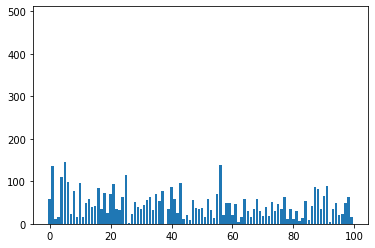

In [38]:
predictionslistSBOX = predictionsSBOX.tolist()
predictionslistSBOXflat = [item for sublist in predictionslistSBOX for item in sublist]

error_list_SBOX = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslistSBOXflat, delaypiekSBOXtest):
  error_list_SBOX.append(round(abs(error1 - error2)))

print(error_list_SBOX)
print(predictionslistSBOXflat)
print(delaypiekSBOXtest)
#visualiseren error
bar = plt.figure(3)
plt.bar(np.arange(0, 100), error_list_SBOX)
plt.ylim(0, 512)
plt.show()


MODEL VOOR ALLE DRIE DE SIGNALEN

In [39]:
#TENSOR VAN 300X1024
samplestotal = tf.concat([samplesASDR, tf.concat([samplesGAUSS, samplesSBOX], axis=0)], axis=0)
samplestotaltest = tf.concat([samplesASDRtest, tf.concat([samplesGAUSStest, samplesSBOXtest], axis=0)], axis=0)
delaytotal = tf.concat([delayASDR, tf.concat([delayGAUSS, delaySBOX], axis=0)], axis=0)


In [40]:
#Model aanmaken
modeltotal = tf.keras.Sequential()
modeltotal.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modeltotal.add(layers.Dense(256, activation='relu'))
modeltotal.add(layers.Dense(64, activation='relu'))
modeltotal.add(layers.Dense(8, activation='relu'))
modeltotal.add(layers.Dense(1))

In [41]:
modeltotal.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 64)                16448     
                                                                 
 dense_18 (Dense)            (None, 8)                 520       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [42]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modeltotal.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [43]:
#Model Trainen
history4 = modelSBOX.fit(samplestotal,
                        delaytotal,
                        epochs=50)

Epoch 1/50
10/10 [==============================] - 0s 8ms/step - loss: 400.6962 - mae: 400.6962
Epoch 2/50
10/10 [==============================] - 0s 10ms/step - loss: 321.7882 - mae: 321.7882
Epoch 3/50
10/10 [==============================] - 0s 10ms/step - loss: 291.9877 - mae: 291.9877
Epoch 4/50
10/10 [==============================] - 0s 9ms/step - loss: 283.9713 - mae: 283.9713
Epoch 5/50
10/10 [==============================] - 0s 10ms/step - loss: 278.3263 - mae: 278.3263
Epoch 6/50
10/10 [==============================] - 0s 9ms/step - loss: 274.6407 - mae: 274.6407
Epoch 7/50
10/10 [==============================] - 0s 8ms/step - loss: 266.8085 - mae: 266.8085
Epoch 8/50
10/10 [==============================] - 0s 9ms/step - loss: 260.2737 - mae: 260.2737
Epoch 9/50
10/10 [==============================] - 0s 8ms/step - loss: 245.4943 - mae: 245.4943
Epoch 10/50
10/10 [==============================] - 0s 8ms/step - loss: 238.4851 - mae: 238.4851
Epoch 11/50
10/10 [=======

In [44]:
predictionstotal = modeltotal.predict(samplestotaltest)

10/10 [==============================] - 0s 4ms/step


[597, 606, 552, 599, 559, 560, 563, 543, 560, 542, 611, 568, 571, 574, 557, 542, 607, 547, 587, 576, 589, 599, 608, 598, 548, 547, 612, 565, 549, 549, 546, 580, 545, 580, 552, 612, 571, 554, 581, 611, 601, 557, 556, 609, 583, 590, 598, 553, 555, 599, 559, 599, 577, 570, 586, 587, 563, 575, 597, 544, 568, 582, 542, 558, 552, 583, 567, 596, 547, 593, 592, 608, 560, 548, 562, 608, 559, 593, 562, 569, 608, 556, 564, 551, 583, 569, 553, 589, 604, 568, 558, 593, 559, 588, 599, 606, 574, 588, 564, 600, 552, 589, 551, 605, 553, 556, 596, 553, 613, 587, 579, 573, 588, 605, 608, 589, 586, 548, 555, 609, 604, 604, 563, 559, 558, 546, 601, 606, 605, 552, 544, 566, 604, 558, 583, 609, 599, 609, 608, 576, 590, 573, 595, 601, 599, 603, 558, 560, 544, 602, 542, 560, 603, 573, 614, 590, 596, 580, 550, 577, 598, 590, 569, 571, 564, 604, 589, 607, 596, 597, 591, 547, 570, 556, 579, 547, 566, 605, 598, 605, 605, 567, 550, 595, 589, 559, 606, 542, 543, 578, 542, 556, 612, 571, 585, 605, 547, 576, 594, 570,

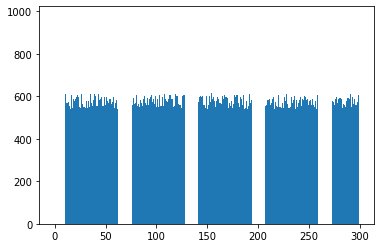

In [45]:
predictionslisttotal = predictionstotal.tolist()
predictionslisttotalflat = [item for sublist in predictionslisttotal for item in sublist]

delaypiektotaltest = delaypiekASDRtest + delaypiekGAUSStest + delaypiekSBOXtest

error_list_total = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslisttotalflat, delaypiektotaltest):
  error_list_total.append(round(abs(error1 - error2)))

print(error_list_total)
print(predictionslisttotalflat)
print(delaypiektotaltest)
#visualiseren error
bar = plt.figure(4)
plt.bar(np.arange(0, 300), error_list_total)
plt.ylim(0, 1024)
plt.show()




https://stackoverflow.com/questions/59737875/keras-change-learning-rate 